### Imports

In [5]:
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
import time

### Obtain and Prepare Data

In [6]:
start = datetime.strptime('2020-01-02','%Y-%m-%d')
end = datetime.strptime('2022-02-28','%Y-%m-%d')

df = data.DataReader('ETH-USD',start=start, end=end, data_source='yahoo')
df = df[:1500]['Close']

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(df).reshape(-1,1))

In [8]:
training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:]

In [9]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [11]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

### Build and Train LSTM

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [13]:
model=Sequential() 
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1))) 
model.add(LSTM(50,return_sequences=True)) 
model.add(LSTM(50)) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
start= time.time()
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)
end=time.time()

Epoch 1/100
7/7 [==============================] - 5s 248ms/step - loss: 0.0395 - val_loss: 0.0308
Epoch 2/100
7/7 [==============================] - 1s 117ms/step - loss: 0.0106 - val_loss: 0.0383
Epoch 3/100
7/7 [==============================] - 1s 116ms/step - loss: 0.0050 - val_loss: 0.0898
Epoch 4/100
7/7 [==============================] - 1s 110ms/step - loss: 0.0056 - val_loss: 0.0088
Epoch 5/100
7/7 [==============================] - 1s 121ms/step - loss: 0.0041 - val_loss: 0.0106
Epoch 6/100
7/7 [==============================] - 1s 110ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 7/100
7/7 [==============================] - 1s 114ms/step - loss: 0.0037 - val_loss: 0.0086
Epoch 8/100
7/7 [==============================] - 1s 115ms/step - loss: 0.0038 - val_loss: 0.0077
Epoch 9/100
7/7 [==============================] - 1s 119ms/step - loss: 0.0031 - val_loss: 0.0102
Epoch 10/100
7/7 [==============================] - 1s 114ms/step - loss: 0.0026 - val_loss: 0.0073
Epoch 11/

7/7 [==============================] - 1s 113ms/step - loss: 5.1854e-04 - val_loss: 0.0116
Epoch 82/100
7/7 [==============================] - 1s 111ms/step - loss: 4.8268e-04 - val_loss: 0.0144
Epoch 83/100
7/7 [==============================] - 1s 111ms/step - loss: 4.9467e-04 - val_loss: 0.0196
Epoch 84/100
7/7 [==============================] - 1s 115ms/step - loss: 5.4220e-04 - val_loss: 0.0216
Epoch 85/100
7/7 [==============================] - 1s 111ms/step - loss: 6.6586e-04 - val_loss: 0.0068
Epoch 86/100
7/7 [==============================] - 1s 110ms/step - loss: 6.7609e-04 - val_loss: 0.0176
Epoch 87/100
7/7 [==============================] - 1s 110ms/step - loss: 5.5339e-04 - val_loss: 0.0119
Epoch 88/100
7/7 [==============================] - 1s 110ms/step - loss: 4.7964e-04 - val_loss: 0.0149
Epoch 89/100
7/7 [==============================] - 1s 116ms/step - loss: 4.7505e-04 - val_loss: 0.0148
Epoch 90/100
7/7 [==============================] - 1s 112ms/step - loss: 4.8

### Make Predictions

In [15]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Visualize Results

<function matplotlib.pyplot.show(close=None, block=None)>

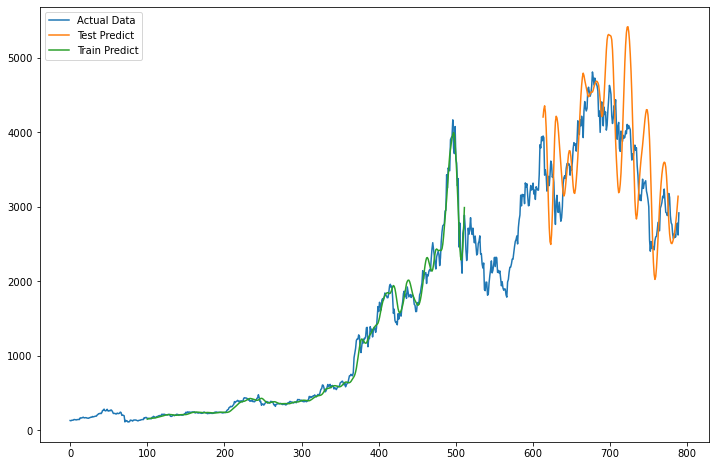

In [16]:
look_back=time_step
trainPredictPlot=np.empty_like(data)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot=np.empty_like(data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1,:] = test_predict

plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)
plt.legend(['Actual Data','Test Predict','Train Predict'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

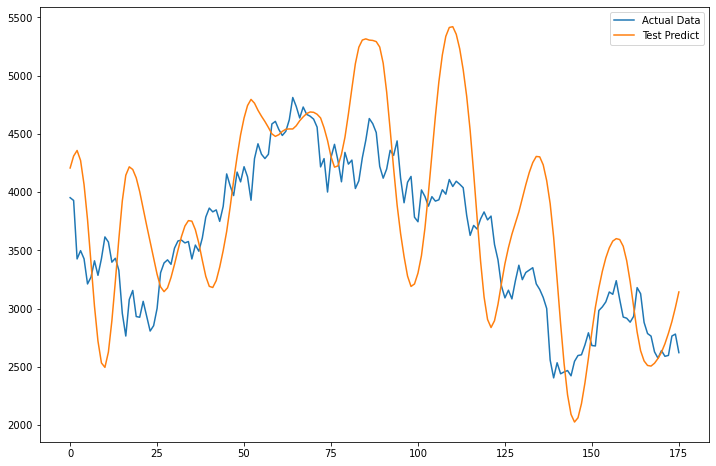

In [17]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data)[len(train_predict)+(look_back*2)+1:len(data)-1])
plt.plot(test_predict)
plt.legend(['Actual Data','Test Predict'])
plt.show

### Evaluation

In [18]:
from sklearn.metrics import mean_squared_error
test_predict=model.predict(X_test)
print('MSE:',mean_squared_error(y_test, test_predict))

MSE: 0.01732310737496416


In [19]:
print('Volatility:',np.log(df/df.shift()).std()*252**0.5)

Volatility: 0.8524482184431009


In [20]:
print('Time taken for training in seconds:',end-start)

Time taken for training in seconds: 82.36412692070007
